# Assignment 1

In this assignment you will be implementing some components of neural networks in numpy from scratch (all your code should be vectorized; and you shouldn’t use any library besides numpy and matplotlib). Base meta classes for the various activations, layers and optimizers are provided; all of your implementations must be classes that inherit from the appropriate base meta class. **When implementing backwards passes, please include in Markdown an analytical derivation of the backwards pass.**

# Step 1: Fully-connected neural networks


## General comments

In this step you will implement all the components you need to construct and train a fully-connected neural network:  the forward and backwards passes for various activations and types of layers, a loss (baked into the SoftMax class), a class to hold the stacked layers together and a couple of optimizers. 

The forward pass is relatively straightforward: each layer outputs an array that the following layer takes as its input. The backwards pass, on the other hand, is a bit more complicated and to be able to complete it, you need to both have the incoming gradient and the original input to each layer, represented by the variable "original_input" in our code. The gradient returned by the backward() call of any given layer is then used as input for the backward() call of the layer immediately preceding it.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Activation Functions

Implement the forwards and backwards passes for the following activations: a) Sigmoid, $\sigma(x) = \frac{1}{1+e^{-x}}$; b) Tanh, tthat returns the tangent hyperbolic function of its input,  $y = tanh(x)$. The ReLU class is done for you as an example.

**Note that defining the __ call __ function allows you to avoid calling the forward function directly, i.e. instead of calling ReLU.forward(x), you should call ReLU(x) instead (for example).**

##Backprop result for Sigmoid activation function

 σ = $\frac{1}{1+\mathrm{e}^{-z}}$

 let $u = 1+\mathrm{e}^{-z}$

$\frac{\partial{h_i}}{∂{z}} = \frac{\partial{h_i}}{∂{u}}.\frac{\partial{u}}{∂{z}}$

$=(\frac{-1}{u^2}).(-\mathrm{e}^{-z})$

$=\frac{1}{1+\mathrm{e}^{-z}}.\frac{\mathrm{e}^{-z}}{1+\mathrm{e}^{-z}}$

adding and subtracting 1 from nummenator we get

$=\frac{1}{1+\mathrm{e}^{-z}}.\frac{1+\mathrm{e}^{-z}-1}{1+\mathrm{e}^{-z}}$

$=\frac{1}{1+\mathrm{e}^{-z}}.(\frac{1+\mathrm{e}^{-z}}{1+\mathrm{e}^{-z}}-\frac{1}{1+\mathrm{e}^{-z}})$

$=\frac{1}{1+\mathrm{e}^{-z}}(1 - \frac{1}{1+\mathrm{e}^{-z}})$

$=\mathbf{h_i(1-h_i)}$



## backprop result for Tanh activation function

tanh = $\frac{\mathrm{e}^{z}-\mathrm{e}^{-z}}{\mathrm{e}^{z}+\mathrm{e}^{-z}}$

applying u/v formulae we get:

$= \frac{(\mathrm{e}^{z}+\mathrm{e}^{-z})(\mathrm{e}^{z}+\mathrm{e}^{-z})-(\mathrm{e}^{z}-\mathrm{e}^{-z})(\mathrm{e}^{z}-\mathrm{e}^{-z})}{(\mathrm{e}^{z}+\mathrm{e}^{-z})^2}$

$= \frac{(\mathrm{e}^{z}+\mathrm{e}^{-z})^2-(\mathrm{e}^{z}-\mathrm{e}^{-z})^2}{(\mathrm{e}^{z}+\mathrm{e}^{-z})^2}$

$=1 - (\frac{\mathrm{e}^{z}-\mathrm{e}^{-z}}{\mathrm{e}^{z}+\mathrm{e}^{-z}})^2$

$= \mathbf{1-tanh(z)^2}$

In [ ]:
import abc
# Abstract base class for all activation classes
class Activations(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self,x):
        return

    @abc.abstractmethod
    def backward(self, grad,original_input):
        return
    
class ReLU(Activations):    
    def forward(self,x):
        return np.maximum(0,x)
    
    def backward(self, grad,original_input):
        #this assumes that the original input to this layer has been saved somewhere else
        x = original_input
        return grad*(x>0)
    
    def __call__(self,x,mode=None):
        return self.forward(x)

class Sigmoid(Activations):
    def forward(self,x):
        return 1/(1 + (np.exp(-x)))
    
    def backward(self, grad,original_input):
        x = original_input
        return grad*(self.forward(x)*(1-self.forward(x)))
        
    def __call__(self,x,mode=None):
        return self.forward(x)
        
class Tanh(Activations):
    def forward(self,x):
        return ((np.exp(x))-(np.exp(-x)))/((np.exp(x))+(np.exp(-x)))
    
    def backward(self, grad,original_input):
        x = original_input
        return (grad*(1-(self.forward(x)**2)))
        
    def __call__(self,x,mode=None):
        return self.forward(x)

# 2. Softmax Cross Loss

Implement an activation (“SoftmaxCrossLoss”) that has two modes of operation: a) if a target, $y_{true}$, is provided then it operates in the same manner as the Pytorch CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (basically the usual softmax activation plus a cross-entropy loss); b) if no target $y_{true}$ is provided, then the forward pass just returns the softmax of the input (no backwards pass needs to be implemented for this mode): for a vector $\mathbf{x}=(x_1,x_2, \cdots, x_n)$, Softmax$(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$ (when using batches this operation should be done for each vector in the batch). 

While implementing softmax shift your input by using shifted_x = x - np.max(x, axis=1, keepdims=True). This does not affect the result of the softmax operation and improves numerical stability.

Note that "mode" is included in this class's function calls just to keep a unified interface for use in the fully-connected neural network.

## Backprop result for softmax cross loss

$y_i = Softmax =\frac{\mathrm{e}^{z_i}}{∑_j{\mathrm{e}^{z_j}}}$

(i) finding derivative w.r.t $\mathrm{z_j}$

$\frac{∂{y_i}}{∂{z_j}} = \frac{∂{(\frac{\mathrm{e}^{z_i}}{∑_j{\mathrm{e}^{z_j}}}})}{∂{\mathrm{z}_{j}}}$

$= \frac{0 - \mathrm{e}^{z_i}\mathrm{e}^{z_j}}{(∑_j{\mathrm{e}^{z_j}})^2} = 
-\frac{{\mathrm{e}^{z_i}\mathrm{e}^{z_j}}}{(∑_j{\mathrm{e}^{z_j}})^2}$

$\frac{∂{y_i}}{∂{z_j}} = -\frac{\mathrm{e}^{z_i}}{\sum\mathrm{e}^{z_j}}.\frac{\mathrm{e}^{z_j}}{\sum\mathrm{e}^{z_j}} $

$\frac{∂{y_i}}{∂{z_j}} = \mathbf{-y_i.y_j}$

(ii) finding derivative w.r.t $z_i$

$\frac{∂{y_i}}{∂{z_i}} = \frac{∂{(\frac{\mathrm{e}^{z_i}}{∑_j{\mathrm{e}^{z_j}}}})}{∂{\mathrm{z}_{i}}} $

$= \frac{∑\mathrm{e}^{z_j}.\mathrm{e}^{z_i} - \mathrm{e}^{z_i}.\mathrm{e}^{z_i}}{(\sum_j\mathrm{e}^{z_j})^2}$

$= \frac{\mathrm{e}^{z_i}}{\sum_j\mathrm{e}^{z_j}} . \frac{∑\mathrm{e}^{z_j} - \mathrm{e}^{z_i}}{\sum_j\mathrm{e}^{z_j}}$

$\frac{∂{y_i}}{∂{z_i}} = \mathbf{y_i(1-y_i)}$


now, using cross entropy loss $L_{CE} = -t_jlog(y_j)$ calculate derivative of loss w.r.t all inputs in softmax ie $z_i$

$\frac{\partial{L_{CE}}}{\partial{z_i}} = \frac{\partial{(\sum_jt_jlog(y_j)}}{\partial{z_i}}$

$=-\sum_jt_j \frac{\partial{log(y_j)}}{∂z_i}$

$=\sum_jt_j\frac{1}{y_j}\frac{\partial(y_j)}{\partial{z_i}}$

now we already calculated $\frac{\partial(y_j)}{\partial{z_i}}$ in (i) and (ii) we get

$-(\frac{t_i}{y_i}\frac{∂(y_i)}{∂z_i} - \sum_j\frac{t_j}{y_j}\frac{∂y_j}{∂z_i})$

$-(\frac{t_i}{y_i}.y_i(1-y_i)) - \sum_j\frac{t_j}{y_j}(-y_jy_i)$ using (i) and (ii)

$=-t_i+t_iy_i+∑_j(t_jy_i)$

$=-t_i + t_iy_i + y_i∑_j{t_j}$

$= y_i(t_i+\sum_jt_j)-t_i$

$= \mathbf{y_i - t_i}$


In [ ]:
class SoftMaxCrossLoss(Activations):
    def __init__(self):
        self.probs = None
        self.y = None

    def forward(self,x, y=None):
        #y being none should make this return simply a softmax activation: we are in testing mode
        #y is not none, you should return the cross-entropy loss using the softmax activations
        if y is None:
          exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
          self.probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
          return self.probs
        else:
          self.y = y
          exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
          x_softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)
          loss = -np.sum(self.y*np.log(x_softmax))/x.shape[0]
          return loss
        
    def backward(self, grad,original_input):
        return (grad*(original_input - self.y))
    
    def __call__(self,x,y=None, mode=None):
        return self.forward(x,y)

# 3. LAYERS

Implement three layers (with both forward and backwards passes): a) an AffineLayer (with input dimension input_dim and hidden units hidden_dim), whose forward pass returns $Y=Xw^T + b$, where w and b are the weights and bias respectively; b) an Inverted Dropout (https://machinelearning.wtf/terms/inverted-dropout/) layer that keeps weights with probability p; c) **Only for 6505 students**: a BatchNorm layer.

Note that the gradients of the parameters of each layer should be kept inside their respective layers. Dropout and Batchnorm behave different based on whether we are in "train" or "test" mode.

## Affine layer Forward and backward Pass

<img src = 'https://drive.google.com/uc?id=1d4swWPTyMJ3JOJe9W56rRHa8PuXhBE6H
'>

##1. forward Pass:

$Z_i = ∑_j^nw_{ij}^{(1)}x_j + b_{ij}^{(1)}$ or $\mathbf{W}^{(1)}\mathbf{x}+\mathbf{b}$

$h_i = σ(z_i)$

$y_k = ∑_i^nw_{kj}^{(2)}h_i+b_{kj}^{(2)}$ or  $\mathbf{W}^{(2)}\mathbf{x}+\mathbf{b}$

$L = \frac{1}{2}(y_k-t_k)^2$ or $\frac{1}{2}||\mathbf{y}-\mathbf{t}||^2$ 

##2. Backward Pass:

$\bar{L}_{se} = 1$

$\bar{y}_k = \bar{L}_{se}.\frac{\partial{L_{se}}}{\partial{y_k}}$ = $\bar{L}_{se}(y_k-t_k)$ 

$\bar{w}_{ij}^{(2)} = \bar{y}_k . \frac{∂y_k}{∂{w}_{ij}^{(2)}} = \bar{y}_k .h_i$

$\bar{b}_{ij}^{(2)} = \bar{y}_k . \frac{∂y_k}{∂{b}_{i}^{(2)}} = \bar{y}_k .1$

$\bar{h}_{1} = \bar{y}_1 . \frac{∂y_1}{∂h_1} + \bar{y}_2 . \frac{∂y_2}{∂h_1} = \bar{y}_1 . w_{kj}^{(2)} + \bar{y}_2 . w_{kj}^{(2)}$ or $\mathbf{W^{(2)}.\bar{y}}$

$\bar{h}_{2} = \bar{y}_1 . \frac{∂y_2}{∂h_2} + \bar{y}_2 . \frac{∂y_2}{∂h_2} = \bar{y}_1 . w_{kj}^{(2)} + \bar{y}_2 . w_{kj}^{(2)}$ or $\bar{h}_k = \mathbf{W^{(2)}.\bar{y}}$

$\bar{z}_k = \bar{h}_k. \frac{\partial{z}_k}{∂h_k} = \bar{h}_k.σ(z_i)$

$\bar{w}_{ij}^{(1)} = \bar{z}_k. \frac{\partial{z_k}}{\partial{w_{ij}^{(1)}}} =\bar{z}_k.x_j $

$\bar{b}_{i}^{(1)} = \bar{z}_k. \frac{\partial{z_k}}{\partial{b_{i}^{(1)}}} =\bar{z}_k.1 $

## Batch Norm layer Forward and backward Pass

<img src='https://drive.google.com/uc?id=1a454-ouEXwpXwuyEU6zEu6LbN_CbGl18'>

## 1. Forward pass

$\mu = \frac{1}{m}\sum_{i=1}^mx_i$

$\sigma = \frac{1}{m}\sum_{i=1}^m(x_i - \mu)^2$

$\hat{X}_i = \frac{x_i - \mu}{\sqrt{\sigma + ϵ}}$

$yi = γ\hat{X}_i + β$

## 2.backward pass

$\bar{L} = 1$

$\mathbf{\bar{Y}_i} = \frac{∂L}{∂Y_i} = \frac{∂L}{∂L} × \frac{∂L}{∂y_i} = \mathbf{ \bar{L}.\frac{∂L}{∂y_i}}$


$\mathbf{\hat{γ}} = \frac{\partial{L}}{\partial{γ}}= \frac{∂L}{∂Y_i} \times \frac{∂y_i}{∂γ} = \bar{Y}_i × \frac{∂(\gamma\hat{X_i}+β)}{∂γ} = \mathbf{\bar{Y}_i\hat{x}_i}$

$\mathbf{\bar{β}} = \frac{\partial{L}}{∂β} = \frac{\partial{L}}{∂Y_i} × \frac{\partial{Y_i}}{∂γ} =  \bar{Y}_i ×\frac{∂(\gamma\hat{X_i}+β)}{∂β} = \mathbf{\bar{Y}_i (1)}$

$\mathbf{\bar{\hat{X}}_i} = \frac{∂L}{∂\bar{\hat{X}}_i} = \frac{∂L}{∂Y_i}×\frac{∂Y_i}{∂\bar{\hat{X}}_i} = \bar{Y}_i × \frac{∂{(γ\hat{X}_i + β)}}{∂{\hat{X}_i}} = \mathbf{\bar{Y}_i(γ)}$

$\mathbf{\bar{σ}} = \frac{∂L}{∂σ} = \frac{∂L}{∂\hat{X}_i}×\frac{∂\hat{X}_i}{∂σ} = \bar{\hat{X}}_i × \frac{∂{\frac{x_i - μ}{\sqrt{σ+ϵ}}}}{∂σ}  = \bar{\hat{X}}_i (X_i - μ)\frac{∂{(\frac{1}{\sqrt{σ+ϵ}})}}{∂σ} = \mathbf{ \bar{\hat{X}}_i (X_i - μ)(-\frac{1}{2} (σ+ϵ)^{-\frac{3}{2}})}$

$\bar{μ} = \frac{∂L}{∂μ} = \frac{∂L}{∂σ} × \frac{∂σ}{∂μ} + \frac{∂L}{∂{\hat{X}_i}} × \frac{∂\hat{X}_i}{∂{μ}}$ using multivariate chain rule

 $= \bar{σ}×\frac{∂{\frac{1}{m}\sum_{i=1}^m (X_i - \mu)^2}}{∂μ} + \bar{\hat{X}}_i × \frac{∂(\frac{X_i - \mu}{\sqrt{σ+μ}})}{∂μ}  = \bar{σ}(2)(\frac{(X_i-μ)(-1)}{m}) + \bar{\hat{X}}_i (\frac{1}{\sqrt{σ+ϵ}})(-1)$

 $\mathbf{\bar{μ}= \bar{σ}∑_{i=1}^m\frac{-2(X_i - μ)}{m} + ∑_{i=1}\bar{\hat{X}}_i (-\frac{1}{\sqrt{σ+ϵ}}) }$

 $\bar{X}_i = \frac{∂L}{∂X_i} = \frac{∂L}{∂\hat{X}_i} × \frac{∂{\hat{X}_i}}{∂X_i} + \frac{∂L}{\partial{\mu}} \times \frac{∂μ}{∂X_i}$ using multi variate chain rule

 $= \bar{\hat{X}}_i ×\frac{∂{(\frac{Xi - μ}{\sqrt{σ+ϵ}}})}{∂X_i} + \bar{μ} × \frac{∂{\frac{1}{m}∑_{i=1}^mX_i}}{∂X_i} + \bar{σ}\frac{∂{\frac{1}{m}∑_{i=1}^m(X_i - μ)^2}}{∂X_i}$

 $= \bar{\hat{X}}_i\frac{1}{\sqrt{σ+μ}} + \bar{\mu}(\frac{1}{m})(1) + \bar{σ}×\frac{1}{m}2(X_i - μ)(1)$

 $\mathbf{\bar{X_i} = \bar{\hat{X}}_i\frac{1}{\sqrt{σ+μ}} + \bar{\mu}(\frac{1}{m}) + \bar{σ}(\frac{2(X_i - μ)}{m})}$

##Dropout Layer forward and backward pass

## 1. Forward Pass

$\mathbf{out = X × mask}$

##2. backward pass

$\frac{∂L}{∂X} = \frac{∂L}{∂out} × \frac{∂out}{∂X}$

$ = grad × \frac{∂(X × mask)}{∂X}$

$= \mathbf{grad \times mask}$

In [ ]:
class Layers(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self,x):
        return 
    
    @abc.abstractmethod
    def backward(self, grad,original_input):
        return
        
class AffineLayer(Layers):
    def __init__(self, input_dim, hidden_units):
        ran = np.sqrt(1/input_dim)
        
        #Initializing the weights and bias, in that order
        self.parameters = [np.random.uniform(-ran,ran,(hidden_units,input_dim)),
                           np.random.uniform(-ran,ran,hidden_units)]
        
        self.grads = [np.zeros_like(self.parameters[0]),np.zeros_like(self.parameters[1])]

        self.w_momentum_list = [0]
        self.b_momentum_list = [0]
        self.w_velocity = np.zeros_like(self.parameters[0])
        self.b_velocity = np.zeros_like(self.parameters[1])

        self.m_dw = np.zeros_like(self.parameters[0])
        self.m_db = np.zeros_like(self.parameters[1])
        self.v_dw = np.zeros_like(self.parameters[0])
        self.v_db = np.zeros_like(self.parameters[1])
        self.itr = 0

    def forward(self,x):
        out = np.dot(x,self.parameters[0].T) + self.parameters[1]
        return out
        
    def backward(self, grad,original_input):
        w = self.parameters[0]
        b = self.parameters[1]
        self.grads[0] = np.dot(grad.T,original_input)
        self.grads[1] = np.sum(grad,axis=0)
        grad_x = np.dot(grad,w)
        return grad_x
        
    def __call__(self,x,mode=None):
        return self.forward(x)
        
            
class BatchNorm(Layers):
    def __init__(self,input_dim,eps,mom):
        ran = np.sqrt(1/input_dim)
        self.X_hat = None
        # [gamma, beta]
        self.parameters = [np.ones(input_dim),np.zeros(input_dim)]
        #[dgamma, dbeta]
        self.grads = [np.zeros_like(self.parameters[0]),np.zeros_like(self.parameters[1])]
        self.running_mean = np.zeros(input_dim)
        self.running_var = np.zeros(input_dim)
        self.batch_mean = None
        self.batch_var = None
        self.eps = eps
        self.m = input_dim
        self.mom = mom

    def forward(self,x,mode):
        N,D = x.shape

        if mode == 'train':
          self.batch_mean = np.mean(x,axis=0)
          self.batch_var = np.var(x,axis=0)
          self.X_hat = (x-self.batch_mean.T)/np.sqrt(self.batch_var.T + self.eps)
    
          self.running_mean = self.mom * self.running_mean + (1 - self.mom) * self.batch_mean
          self.running_var = self.mom * self.running_var + (1 - self.mom) * self.batch_var

          out = self.X_hat * self.parameters[0] + self.parameters[1]
          return out
        elif mode == 'test':
          x_cap = (x - self.running_mean) / np.sqrt(self.running_var)
          return ((x_cap * self.parameters[0] ) + self.parameters[1])
          

    def backward(self, grad,original_input):
        x = original_input
        xcap_hat = grad * self.parameters[0]
        batch_var_hat =  np.sum(xcap_hat*(x-self.batch_mean)*(-0.5)*(self.batch_var + self.eps)**(-1.5),axis=0)
        batch_mean_hat = batch_var_hat * (np.sum((-2*(x-self.batch_mean)))/self.m) + np.sum(xcap_hat*(-1/np.sqrt(self.batch_var + self.eps)),axis=0)
        x_hat = (xcap_hat * (1/np.sqrt(self.batch_var + self.eps))) + (batch_mean_hat/self.m) + (batch_var_hat * ((2*(x-self.batch_mean))/self.m))
        gamma_hat = np.sum(grad * self.X_hat,axis=0)
        beta_hat = np.sum(grad,axis=0)

        self.grads[0] = gamma_hat
        self.grads[1] = beta_hat
        grad_x = x_hat

        #return gradient with respect to the original input to this layer
        return grad_x
    
    def __call__(self,x,mode):
      return self.forward(x,mode)
        
class Dropout(Layers):
    def __init__(self,p):
        self.p = p
        self.mask = None
    
    def forward(self,x,mode):
        out = None
        self.mode = mode
        if mode == 'train':
          self.mask = (np.random.rand(*x.shape) < (1-self.p)) / (1-self.p)
          out = x * self.mask
        elif mode =='test':
          out = x
        return out
    
    def backward(self, grad,original_input):
        grad_x = None
        grad_x = grad * self.mask
        #return gradient with respect to the original input to this layer
        return grad_x
    
    def __call__(self,x,mode="test"):
        return self.forward(x,mode)

# 4. FCNN

Implement a fully connected neural network that takes as input some user-defined layers and has both forward and backward passes (you should use the forward and backward passes from the previously defined layers).

In [ ]:
class FCNN:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []
        self.loss_list = []
        self.accuracy_List = []

    def forward(self,x,y = None, mode ='test'):
        #Start by adding the input to the original_inputs array that keeps the original_input to each
        #layer in order.
        self.original_inputs = [x.copy()]
        for index,layer in enumerate(self.layers):
          if isinstance(layer,SoftMaxCrossLoss):
            out = layer(self.original_inputs[index],y,mode)
            if mode == 'train':
              self.loss_list.append(out)
          else:
            out = layer(self.original_inputs[index],mode)
          self.original_inputs.append(out)
        return self.original_inputs[-1]
    
    def backward(self): 
        #Pop loss value from the cache
        self.original_inputs.pop()
        grad = 1
        for index,layer in reversed(list(enumerate(self.layers))):
          grad = layer.backward(grad,self.original_inputs.pop(index))
        return grad
            
        
    def __call__(self,x, y = None, mode='test'):
        return self.forward(x,y,mode)

# 5. Optimizers

Implement the following optimizers: a) stochastic gradient descent with momentum; b) **Only for 6505 students**: the Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). These optimizers should take as input a layer and update their parameters according to the gradients stored in the layers.

Note that Adam requires you to keep a track of the running means of gradients. A python dictionary to organize this might prove useful.

In [ ]:
class Optimizer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def step(self,layer):
        return 

class SGD(Optimizer):
    def __init__(self, momentum):
        self.learning_rate = 0.001
        self.momentum = momentum

    def step(self, layer):
      if isinstance(layer,AffineLayer):
        w_velocity = self.momentum*layer.w_velocity - self.learning_rate*layer.grads[0]
        b_velocity = self.momentum*layer.b_velocity - self.learning_rate*layer.grads[1]
        layer.parameters[0] +=  w_velocity
        layer.parameters[1] +=  b_velocity
        layer.w_velocity = w_velocity
        layer.b_velocity = b_velocity
      elif isinstance(layer,BatchNorm):
        layer.parameters[0] -= self.learning_rate*layer.grads[0]
        layer.parameters[1] -= self.learning_rate*layer.grads[1]

    def __call__(self,layer):
        return self.step(layer)


class Adam(Optimizer):
    def __init__(self,learning_rate,beta1,beta2,epsilon):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        
    def step(self, layer):
      if isinstance(layer,AffineLayer):
        layer.itr += 1
        m_dw = self.beta1*layer.m_dw + (1-self.beta1)*layer.grads[0]
        m_db = self.beta1*layer.m_db + (1-self.beta1)*layer.grads[1]

        v_dw = self.beta2*layer.v_dw + (1-self.beta2)*(layer.grads[0]*layer.grads[0])
        v_db = self.beta2*layer.v_db + (1-self.beta2)*(layer.grads[1]*layer.grads[1])

        m_dw_corrected = m_dw/(1-(self.beta1**layer.itr))
        m_db_corrected = m_db/(1-(self.beta1**layer.itr))
        v_dw_corrected = v_dw/(1-(self.beta2**layer.itr))
        v_db_corrected = v_db/(1-(self.beta2**layer.itr))


        layer.parameters[0] = layer.parameters[0] - self.learning_rate* m_dw_corrected/(np.sqrt(v_dw_corrected)+self.epsilon)
        layer.parameters[1] = layer.parameters[1] - self.learning_rate* m_db_corrected/(np.sqrt(v_db_corrected)+self.epsilon)
        layer.m_dw = m_dw
        layer.m_db = m_db
        layer.v_dw = v_dw
        layer.v_db = v_db
      elif isinstance(layer,BatchNorm):
        layer.parameters[0] -= self.learning_rate*layer.grads[0]
        layer.parameters[1] -= self.learning_rate*layer.grads[1]

    def __call__(self,layer):
      return self.step(layer)

# Defining Functions

In [ ]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 1)

In [ ]:
def get_accuracy(predictions, Y):
    return np.mean(get_predictions(predictions)==get_predictions(Y))

In [ ]:
# # Loading the data

train_data = np.load("train_data.npy")
train_targets = np.load("train_targets.npy")

test_data = np.load("test_data.npy")
test_targets = np.load("test_targets.npy")
# test_data = np.load("test.npz")['arr_0']
# test_targets = np.load("test.npz")['arr_1']

# # Define your batch size
# # batch_size = 

In [ ]:
arr = np.array([0,1,2,3,4,5,6,7,8,9])
one_hot_array = one_hot(arr)
one_hot_array = one_hot_array.T

In [ ]:
train_targets = (one_hot(train_targets)).T
test_targets = (one_hot(test_targets)).T

In [ ]:
image_vector_size = 28*28
train_data = train_data.reshape(train_data.shape[0], image_vector_size)
test_data = test_data.reshape(test_data.shape[0], image_vector_size)



# Training Loop

In [ ]:
def MiniBatchSDG(epochs,size,train_data,train_targets,net,optimizer):
  iteractions = train_data.shape[0]/size
  index = np.linspace(train_data.shape[0],size)
  batch_list = np.linspace(0,train_data.shape[0],num=int(train_data.shape[0]/size),dtype=int)
  batches_data = []
  batches_target = []
  optimizer =  SGD(0.9) if(optimizer == 'SGD') else Adam(learning_rate=0.001,beta1=0.9,beta2=0.9,epsilon=1e-8)
  for x in batch_list:
    if x == 0:
      previous_x = x
      continue
    else:
      batches_data.append(train_data[previous_x:x])
      batches_target.append(train_targets[previous_x:x])
      previous_x = x
  for epoch in range(epochs):
    counter = 0
    for Btrain_data,Btrain_targets in zip(batches_data,batches_target):
      counter += 1
      net(Btrain_data,Btrain_targets,'train')
      net.backward()
      for layer in net.layers:
        if isinstance(layer, AffineLayer) or isinstance(layer,BatchNorm):
          optimizer(layer)
    batch_test = net(train_data)
    print("************************",type(optimizer).__name__,"****************************Accuracy************************",type(optimizer).__name__,"****************************")
    net.accuracy_List.append(get_accuracy(one_hot(get_predictions(batch_test)).T,train_targets)) 
    print("Accuaracy after",epoch+1," epochs : ",get_accuracy(train_targets,batch_test)*100)
  print("----------------------------------------Running Test Set---------------------------------------------")
  test_pred = net(test_data)
  print("Test Set Accuaracy is : ",get_accuracy(test_targets,test_pred)*100)
  print("----------------------------------------Running Test Set---------------------------------------------")
  plt.plot(range(epochs*len(batches_data)),net.loss_list,'blue')
  plt.title('Loss decay')
  plt.xlabel('number of training batches seen')
  plt.ylabel('Loss')
  plt.show()


# 6.

Test out several fully connected architectures on the reduced MNIST dataset provided. Feed the dataset to your network in batches and experiment with the batch size. 

a) Experiment with the batch size. Does the batch size impact performance? 

b) Do you do better with two or three layers? Experiment with the hidden units in each layers.

c) Does adding more layers continually improve your results? 

d) Does Dropout help? 

e) What can you say about the difficulty of training as you add layers? 

f) **Only for 6505 students**: Does Batchnorm improve results? 

g) **Only for 6505 students**: Try using the Adam optimizer. Do you converge more quickly? Do you get better results?




**Download train.npz and test.npz from the Assignment 1 Files folder on teams. The data contains several thousand images represented by arrays of shape (28,28); before feeding it to your network you should flatten them so that each image has shape (784,).**

## Which Activation Function is Better? 
As from below results we found out that from the nets with same layers and different activation functions. Relu outperformed all the other activation functions. Reason for these results is that as we saw in our back prop result of sigmoid, the value is clauclated as Sigmoid_Output(1-Sigmoid_Output). And if a unit is very active it will output near to 1 which will make backprop 1(1-1) = 0 similarly if unit is very inactive it will return closer to 0 which will also make backprop 0(1-0) = 0. Hence if units are very active or inactive it will make a that unit inactive. This phenomina is called as **Vanishing Gradient Problem**

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  79.87166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  83.00833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  82.075
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  81.52833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  80.35333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  79.993333

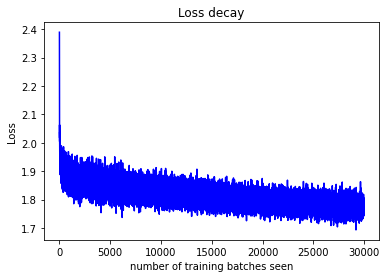

In [ ]:
Best_Model_Sigmoid = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),Sigmoid(),
                           AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),Sigmoid(),
                           AffineLayer(64,10),
                           SoftMaxCrossLoss()])
MiniBatchSDG(50,100,train_data,train_targets,Best_Model_Sigmoid,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  89.95833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  91.01
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  91.61500000000001
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  91.88833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  92.21666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  92.3950000

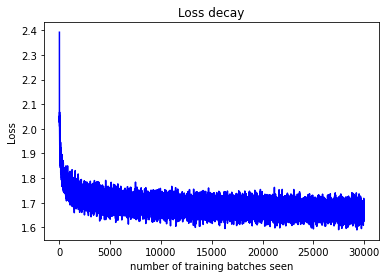

In [ ]:
Best_Model_Tanh = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),Tanh(),
                        AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),Tanh(),
                        AffineLayer(64,10),
                        SoftMaxCrossLoss()])
MiniBatchSDG(50,100,train_data,train_targets,Best_Model_Tanh,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  73.245
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  79.08166666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  87.20666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  89.29666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  90.58333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  91.621666

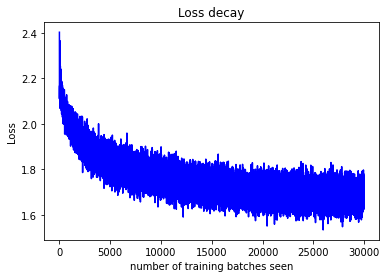

In [ ]:
Best_Model_Relu = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),ReLU(),
                        AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),ReLU(),
                        AffineLayer(64,10),
                        SoftMaxCrossLoss()])
Loss_list = MiniBatchSDG(50,100,train_data,train_targets,Best_Model_Relu,'SGD')

##a) Experiment with the batch size. Does the batch size impact performance?

In this experiment we use three batch sizes 10,100,1024 and we noticed very strange behaviour. Model with batch size 10 generalized more on test data as compared to model with batch size 100. And strangely model with batch size 1024 gave 'nan' in weights.

on research I found out that training model with very large bacth size can result the gradients to explode and model ends up learning nothing this phenomina is known as **Exploding gradient problem**.

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  97.44500000000001
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.14333333333335
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  98.45833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  98.705
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  98.93666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  99.063333

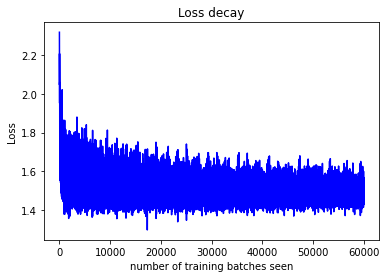

In [ ]:
Batch10_model = FCNN([AffineLayer(784,128),ReLU(),
                       AffineLayer(128,64),ReLU(),
                       AffineLayer(64,10),SoftMaxCrossLoss()])
MiniBatchSDG(10,10,train_data,train_targets,Batch10_model,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  97.365
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.17333333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  98.595
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  98.80666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  99.03166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  99.14833333333334
**

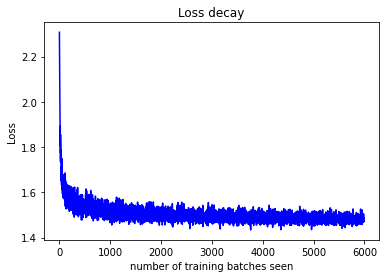

In [ ]:
Batch100_model = FCNN([AffineLayer(784,128),ReLU(),
                        AffineLayer(128,64),ReLU(),
                        AffineLayer(64,10),
                        SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Batch100_model,'SGD')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  9.871666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  9.871666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  9.871666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  9.871666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  9.871666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :

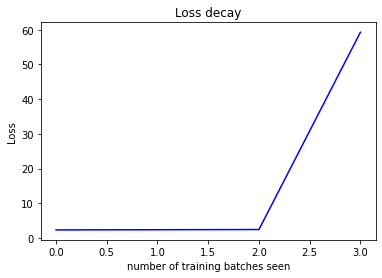

In [ ]:
Batch1024_model = FCNN([AffineLayer(784,128),ReLU(),
                        AffineLayer(128,64),ReLU(),
                        AffineLayer(64,10),
                        SoftMaxCrossLoss()])
MiniBatchSDG(10,1024,train_data,train_targets,Batch1024_model,'SGD')

## b) Do you do better with two or three layers?Experiment with the hidden units in each layers.

Experiment -1 
-----------------------
In experiment 1 we ran two networks one with 2 Affine layers and other with three affine layers.

Results : We found out that model with three affine layer performed much better on training set but struggled generalizing on test set and lead the model to overfitting a little more in model with three layers.

Experiment -2
-----------------------

In this experiment we took 2 models, model 1 had more learnable parameters than model 2 and we found out that model with more learnable parameters performed much better on training set.

### Experiment-1

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  92.85666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  94.02333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  94.74333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  95.24000000000001
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  95.60833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :

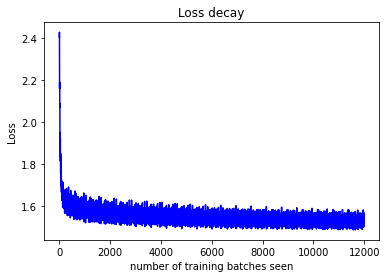

In [ ]:
TwoAffinelayer_network = FCNN([AffineLayer(784,64),Sigmoid(),
                     AffineLayer(64,10),
                     SoftMaxCrossLoss()])
MiniBatchSDG(20,100,train_data,train_targets,TwoAffinelayer_network,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  92.215
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  94.63000000000001
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  95.8
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  96.42833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  96.90166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  97.27166666666666
****

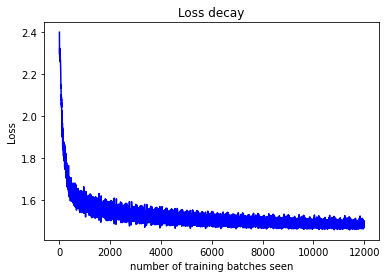

In [ ]:
ThreeAffinelayer_network = FCNN([AffineLayer(784,128),Sigmoid(),
                                AffineLayer(128,64),Sigmoid(),
                                AffineLayer(64,10),
                                SoftMaxCrossLoss()])
MiniBatchSDG(20,100,train_data,train_targets,ThreeAffinelayer_network,'SGD')

### Experiment-2

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  98.11333333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.85000000000001
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  99.20166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  99.39166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  99.56166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :

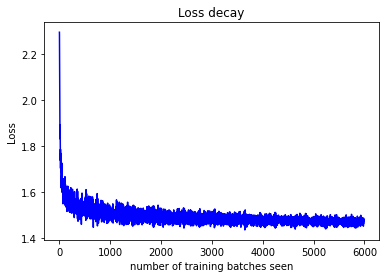

In [ ]:
network1 = FCNN([AffineLayer(784,512),ReLU(),
                 AffineLayer(512,256),ReLU(),
                 AffineLayer(256,10),
                 SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,network1,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  97.24333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.115
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  98.51166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  98.74166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  98.91499999999999
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  99.006666

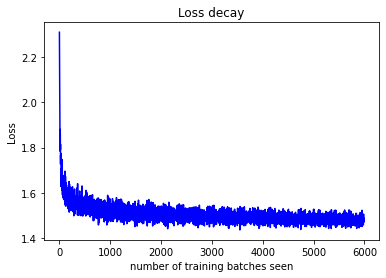

In [ ]:
network2 = FCNN([AffineLayer(784,128),ReLU(),
                 AffineLayer(128,64),ReLU(),
                 AffineLayer(64,10),
                 SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,network2,'SGD')

## c) Does adding more layers continually improve your results? 
No, it lead to overfitting i.e why model failed to generalize test data. As we can see in below experimnet as model with more affine layers had more parameters due to which it worked very well on training set but failed generalizing test set.

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  91.04333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  91.94333333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  92.15333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  92.43666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  92.49833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :

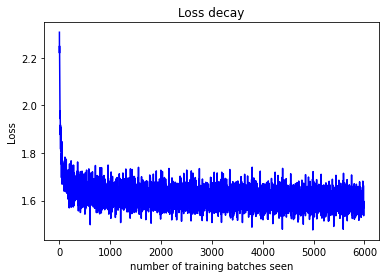

In [ ]:
Model1 = FCNN([AffineLayer(784,64),ReLU(),
                                AffineLayer(64,10),
                                SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Model1,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  97.82833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.55333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  98.98833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  99.09666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  99.08833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :

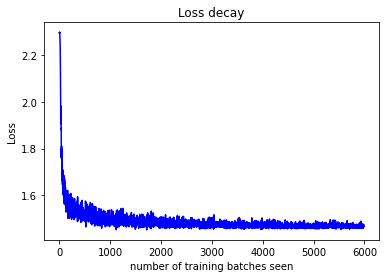

In [ ]:
Model3 = FCNN([AffineLayer(784,512),ReLU(),
                                AffineLayer(512,256),ReLU(),
                                AffineLayer(256,128),ReLU(),
                                AffineLayer(128,64),ReLU(),
                                AffineLayer(64,10),
                                SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Model3,'SGD')

##d) Does Dropout help?
In below experiment we ran different models with and without dropout and find out that model which are without dropout gave more accuaracy on training set but less on testing set. Whereas, models with dropout performed same on both training and testing set. which shows that models without dropout failed generalizing our model which lead to overfitting. Which shows dropout layer acts as a regularizer.

So as in below results, models that contained dropout layer gave same accuaracy result on both train and test set. And have less accuracy than models that didnot had dropout layer which also shows that droput layer is acting as a regulizer and more information is learned by the models that had dropout layer. 


### Without Dropout

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  97.27166666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.14
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  98.46666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  98.74000000000001
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  98.875
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  98.99
***************

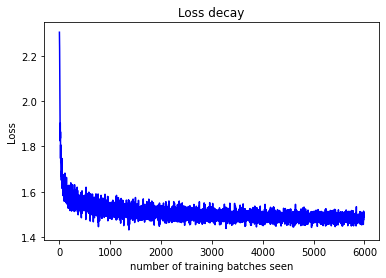

In [ ]:
Relu_Net = FCNN([AffineLayer(784,128),ReLU(),
                 AffineLayer(128,64),ReLU(),
                 AffineLayer(64,10),
                 SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Relu_Net,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  92.58999999999999
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  94.65
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  95.75
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  96.48166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  96.94
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  97.30166666666666
****************

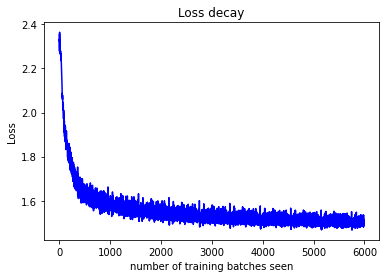

In [ ]:
Sigmoid_Net = FCNN([AffineLayer(784,128),Sigmoid(),
                    AffineLayer(128,64),Sigmoid(),
                    AffineLayer(64,10),
                    SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Sigmoid_Net,'SGD')

### With Dropout

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  91.96166666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  92.98833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  93.785
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  94.35666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  94.69833333333332
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  94.616666

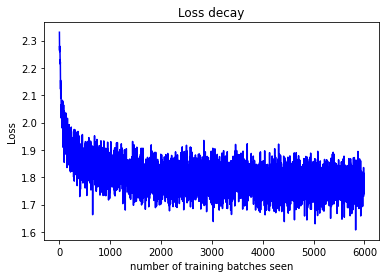

In [ ]:
ReluandDropout_Net = FCNN([AffineLayer(784,128),Dropout(0.5),ReLU(),
                           AffineLayer(128,64),Dropout(0.5),ReLU(),
                           AffineLayer(64,10),
                           SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,ReluandDropout_Net,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  88.435
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  91.00333333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  91.27333333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  91.905
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  92.13833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  92.14333333333333
**

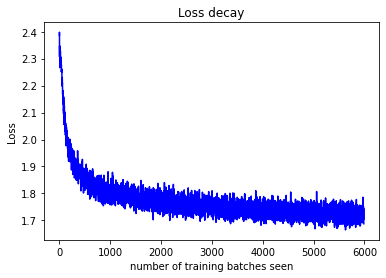

In [ ]:
SigmoidandDropout_Net = FCNN([AffineLayer(784,128),Dropout(0.5),Sigmoid(),
                              AffineLayer(128,64),Dropout(0.5),Sigmoid(),
                              AffineLayer(64,10),SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,SigmoidandDropout_Net,'SGD')

## e) What can you say about the difficulty of training as you add layers?

Adding more fully connected layers means that we are adding more and more learnable parameters to train, as adding more layers will increase number of learnable parameters it takes more time to train our model and also increases overfitting problem.

### Experiment 

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  91.705
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  92.26333333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  92.78
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  93.24166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  93.54833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  93.83666666666667
***

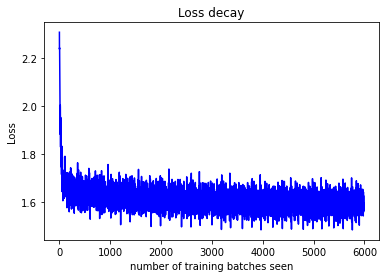

In [ ]:
Shallow_network_Affine = FCNN([AffineLayer(784,64),ReLU(),
                     AffineLayer(64,10),
                     SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Shallow_network_Affine,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  97.83666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  98.59833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  98.895
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  99.13666666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  99.27833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  99.536666

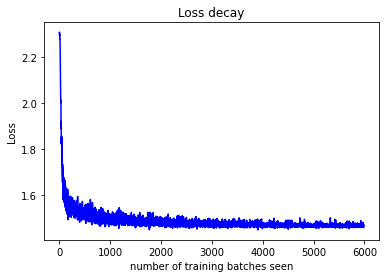

In [ ]:
Deep_network_Affine = FCNN([AffineLayer(784,512),ReLU(),
                     AffineLayer(512,256),ReLU(),
                     AffineLayer(256,128),ReLU(),
                     AffineLayer(128,64),ReLU(),
                     AffineLayer(64,10),
                     SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Deep_network_Affine,'SGD')

## f) Does Batchnorm improve results?

Yes, Batch normalization did impoved results. Actually it helped us to trian our model in less epochs. we did two experiments to showcase our results ie Exp1 and Exp2.

Experiment -1 
----------------
In this experiment we took two models, Model_withoutBathcNorm and Model_withBathcNorm. As name says we had two model one with no batchnorm layer and other one with batchnorm layer and kept rest of the configuration same. we ran just one epoch and from the loss curve of both we found out that loss decay in Model with no batchnorm there was gradual deacrese in loss where as model with batchnorm had a sudden fall of loss in just few batches ie it helped model to learn much faster as compared to model with no batchnorm.

but, you will say why model with no batchnorm showed more accuaracy than with batchnorm. That happend because batchnorm also add a little affect of regularizer. But the main use of batchnorm is to train our model faster in less epochs. 

Experiment -2
---------------
In this experiment we took two models, one with no batchnorm and other with batchnorm. And the model that doesnot have batchnorm layer we ran for 10 epochs, whereas the model with batchnorm we ran for 5 epochs. And we found out that model with batchnorm showed same Accuaracy on train set as we got on network witout batchnorm which we ran for 10 epochs. This showed us that model with batchnorm took nearly half epochs to train our model to same accuracy. Hence it showed with batchnorm we converge quickly.

Secondly, if we compare test set result. Model with batchnorm showed a little affect of regularization also as it showed good results on test set.

### Experiment-1

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  92.41166666666668
----------------------------------------Running Test Set---------------------------------------------
Test Set Accuaracy is :  92.7
----------------------------------------Running Test Set---------------------------------------------


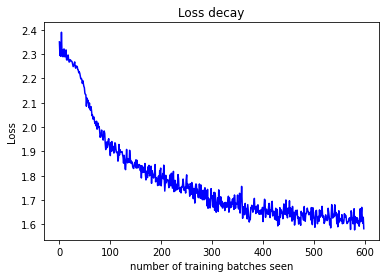

In [ ]:
Model_withoutBathcNorm = FCNN([AffineLayer(784,128),Sigmoid(),
                               AffineLayer(128,64),Sigmoid(),
                               AffineLayer(64,10),
                               SoftMaxCrossLoss()])
MiniBatchSDG(1,100,train_data,train_targets,Model_withoutBathcNorm,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  81.43833333333333
----------------------------------------Running Test Set---------------------------------------------
Test Set Accuaracy is :  81.32000000000001
----------------------------------------Running Test Set---------------------------------------------


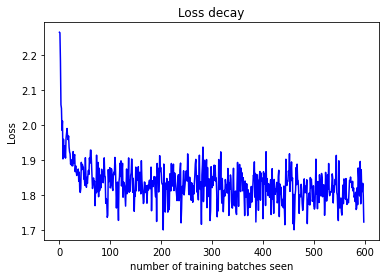

In [ ]:
Model_withBathcNorm = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Sigmoid(),
                            AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Sigmoid(),
                            AffineLayer(64,10),
                            SoftMaxCrossLoss()])
MiniBatchSDG(1,100,train_data,train_targets,Model_withBathcNorm,'SGD')

### Experiment-2

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  91.835
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  92.69833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  93.08999999999999
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  93.46
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  94.07833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  94.65833333333333
***

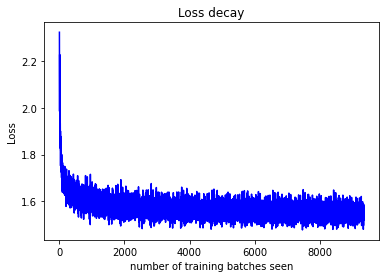

In [ ]:
Shallow_net_NoBatchnorm = FCNN([AffineLayer(784,64),Tanh(),
                                AffineLayer(64,10),
                                SoftMaxCrossLoss()])
MiniBatchSDG(10,64,train_data,train_targets,Shallow_net_NoBatchnorm,'SGD')

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  93.51833333333333
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  94.52666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  95.025
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  95.27166666666666
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  95.46166666666667
----------------------------------------Running Test Set---------------------------------------------
Test Set Accuaracy is :  95.13000000000001
----------------

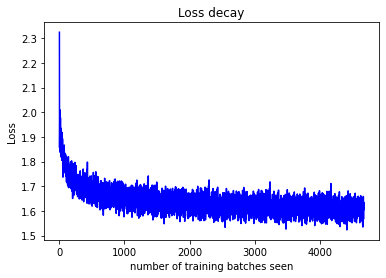

In [ ]:
Shallow_with_batchnorm = FCNN([AffineLayer(784,64),BatchNorm(64,1e-5,0.9),Tanh(),
                                AffineLayer(64,10),
                                SoftMaxCrossLoss()])
MiniBatchSDG(5,64,train_data,train_targets,Shallow_with_batchnorm,'SGD')

## g)Try using the Adam optimizer. Do you converge more quickly? Do you get better results?

Yes, With ADAM opt we were able to converge much faster as compared to SGD. To showcase our results we have peroformed two experiments, Exp-1 and Exp2.

Experiment-1:
------------------
In this experiment we took two networks with same configuration only difference is Model_SGD we ran using SGD optimizer and Model_ADAM we ran with ADAM optimizer.

Results : We found out that from Loss curve that model which was traind with SGD showed more wobbly as compared to one which was trained with ADAM optimizer. Because with ADAM opt it tried to reach optimum more faster that is why loss curve is less wobbly or jittery in model trained with ADAM optimizer.

Moreover, we ran only single epoch and Model that was trained with ADAM optimizer gave us more accuaracy than the other one. Which also showed us that with ADAM optimizer we were able to converge much faster.

Experiment-2:
------------------

In this experiment we took two networks with same configuration, and both trained with different optimizers i.e SGD and ADAM. 

Results: After running 10 epochs, on same config model with different optimizer we found out that model that we ran with ADAM optimizer gave us more accuracy than the one trained with SGD. Which showed us that after running same no of epochs on same config network with ADAM optimizer we were able to converge more quickly as compared to SGD.

### Experiment -1

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  76.71833333333333
----------------------------------------Running Test Set---------------------------------------------
Test Set Accuaracy is :  76.68
----------------------------------------Running Test Set---------------------------------------------


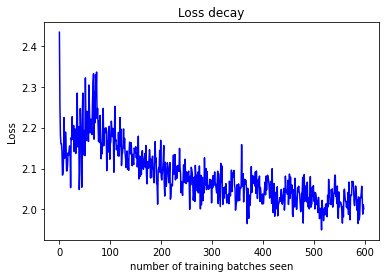

In [ ]:
Model_SGD = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),ReLU(),
                  AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),ReLU(),
                  AffineLayer(64,10),
                  SoftMaxCrossLoss()])
MiniBatchSDG(1,100,train_data,train_targets,Model_SGD,'SGD')

************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 1  epochs :  92.29333333333334
----------------------------------------Running Test Set---------------------------------------------
Test Set Accuaracy is :  92.60000000000001
----------------------------------------Running Test Set---------------------------------------------


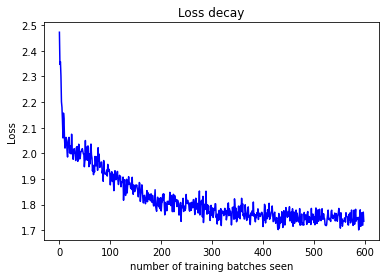

In [ ]:
Model_ADAM = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),ReLU(),
                  AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),ReLU(),
                  AffineLayer(64,10),
                  SoftMaxCrossLoss()])
MiniBatchSDG(1,100,train_data,train_targets,Model_ADAM,'ADAM')

### Experiment-2

************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 1  epochs :  56.43666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 2  epochs :  70.24166666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 3  epochs :  78.02833333333334
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 4  epochs :  83.93666666666667
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 5  epochs :  86.32
************************ SGD ****************************Accuracy************************ SGD ****************************
Accuaracy after 6  epochs :  87.7550000

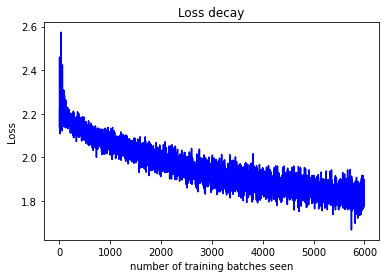

In [ ]:
Model_SGD = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),ReLU(),
                  AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),ReLU(),
                  AffineLayer(64,10),SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Model_SGD,'SGD')

************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 1  epochs :  92.34
************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 2  epochs :  93.71333333333334
************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 3  epochs :  94.24166666666667
************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 4  epochs :  94.71000000000001
************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 5  epochs :  95.00999999999999
************************ Adam ****************************Accuracy************************ Adam ****************************
Accuaracy after 6  epochs :

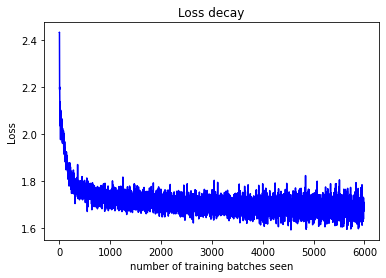

In [ ]:
Model_ADAM = FCNN([AffineLayer(784,128),BatchNorm(128,1e-5,0.9),Dropout(0.5),ReLU(),
                  AffineLayer(128,64),BatchNorm(64,1e-5,0.9),Dropout(0.3),ReLU(),
                  AffineLayer(64,10),SoftMaxCrossLoss()])
MiniBatchSDG(10,100,train_data,train_targets,Model_ADAM,'ADAM')